In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import rfft
from matplotlib import mlab
import pylab as pl

import aifc

In [5]:
from glob import glob

In [6]:
train_filenames = glob('../whale_data/train/*.aiff')

In [7]:
print('There are '+str(len(train_filenames))+' files.' )

There are 30000 files.


Let's calculate the spectrogram for each of them.

In [8]:
# read the labels
import pandas as pd
labels = pd.read_csv("../whale_data/train.csv", index_col = 0)

In [9]:
# names of files which contain aiff
print(labels[labels['label'] == 1].index)

Index([u'train6.aiff', u'train7.aiff', u'train9.aiff', u'train12.aiff',
       u'train28.aiff', u'train31.aiff', u'train32.aiff', u'train55.aiff',
       u'train64.aiff', u'train73.aiff',
       ...
       u'train29967.aiff', u'train29968.aiff', u'train29969.aiff',
       u'train29970.aiff', u'train29971.aiff', u'train29972.aiff',
       u'train29980.aiff', u'train29981.aiff', u'train29991.aiff',
       u'train29992.aiff'],
      dtype='object', name=u'clip_name', length=7027)


In [10]:
whale_labels = labels[labels['label'] == 1].index

In [11]:
whale_labels[0]

'train6.aiff'

In [12]:
import os

In [13]:
whale_sample_file = whale_labels[100] 
whale_aiff = aifc.open(os.path.join('..','whale_data','train',whale_sample_file),'r')
print "Channels:", whale_aiff.getnchannels() 
print "Frames:", whale_aiff.getnframes() 
print "Frame rate (frames per second):", whale_aiff.getframerate()

Channels: 1
Frames: 4000
Frame rate (frames per second): 2000


In [14]:
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent)
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, 1000])

/Users/valentina/anaconda/envs/ooi_demo2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


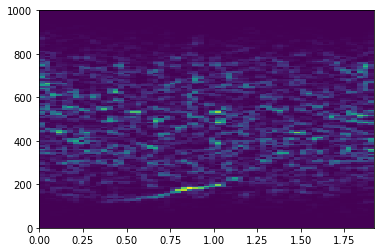

In [15]:
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
PlotSpecgram(P, freqs, bins)

In [16]:
P.shape

(129, 59)

In [17]:
# let's calculate all spectrograms

In [18]:
# create a dictionary which contains all the spectrograms
spec_dict = {}

In [19]:
for filename in train_filenames:
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    P, freqs, bins = mlab.specgram(whale_array, **params)
    spec_dict[filename] = P
    
    

/Users/valentina/anaconda/envs/ooi_demo2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  after removing the cwd from sys.path.


In [20]:
spec_dict[spec_dict.keys()[100]].shape

(129, 59)

In [21]:
# they are all same length I think

In [22]:
# let's put them in standard features x samples format

In [25]:
feature_dict = {}

In [27]:
#for key in spec_dict:
#    feature_dict[key] = spec_dict[key].ravel()

In [26]:
for key in train_filenames:
    feature_dict[key[20:]] = spec_dict[key].ravel()

In [28]:
X = pd.DataFrame(feature_dict)

In [29]:
X.shape

(7611, 30000)

In [30]:
X.columns[0]

'train1.aiff'

In [31]:
# perform PCA & ICA

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
X_transformed = pca.fit(X.T).transform(X.T)

In [ ]:
X_transformed.shape

[0.15526929 0.05026415 0.0291711  0.02402422 0.02074132 0.0121361
 0.00896927 0.00827419 0.00790353 0.0067772  0.00579323 0.00523441
 0.00522199 0.00480358 0.0045191  0.00430878 0.00393677 0.00385985
 0.00363057 0.00354707 0.00340946 0.00338437 0.00332397 0.00326089
 0.00321187 0.00312038 0.00298482 0.00291538 0.00289156 0.00285109]


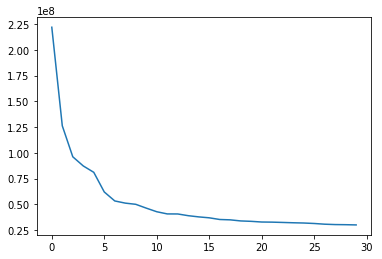

In [33]:
print(pca.explained_variance_ratio_)
plt.plot(pca.singular_values_)

In [ ]:
plt.imshow(X_transformed[:,20].reshape(129,59).T)

In [ ]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=5)
X_transformed = ica.fit(X).transform(X)

In [ ]:
plt.imshow(X_transformed[:,0].reshape(129,59).T)

In [ ]:
# Unsupervised Learning
# I can try to cluster them and plot them with labels 

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_transformed)

In [ ]:
labels['label'][X.columns]

In [ ]:
kmeans.labels_

In [ ]:
(labels['label'] - (1 - kmeans.labels_))

In [ ]:
kmeans.labels_.shape

In [ ]:
X_transformed.shape

In [ ]:
plt.scatter(X_transformed[:,0],X_transformed[:,1],[],kmeans.labels_)

In [ ]:
X_transformed.shape

In [ ]:
# supervised prediction

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X.T.iloc[:15000,:], np.array(labels['label'][X.columns][:15000]))
print(clf.feature_importances_)
#print(clf.predict([[0, 0, 0, 0]]))

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.23917337e-04
 3.81515769e-05 0.00000000e+00]


In [37]:
np.sum(np.abs(clf.predict(X.T.iloc[15000:,:])-labels['label'][X.columns][15000:]))/15000.

0.19713333333333333

In [38]:
X_transformed.shape

(7611, 30)

In [39]:
np.sum(np.array(labels['label'][:15000]))

3313

In [40]:
np.sum(np.abs(clf.predict(X.T.iloc[:15000,:]) - labels['label'][X.columns][:15000]))/15000.

0.04373333333333333

In [43]:
np.sum(np.abs(clf.predict(X.T.iloc[15000:,:]) - labels['label'][X.columns][15000:]))/15000.

0.19713333333333333

In [42]:
np.array(labels['label']).sum()

7027

In [45]:
np.sum(np.abs(clf.predict(X.T.iloc[:15000,:])))

2907

In [52]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_transformed[:15000,:], np.array(labels['label'][X.columns][:15000]))
print(clf.feature_importances_)

[0.08598452 0.08002381 0.03512488 0.06172032 0.04608274 0.05071678
 0.02359616 0.04853678 0.01229696 0.01195773 0.01059296 0.06396772
 0.02482635 0.02398492 0.01235075 0.00870697 0.06054303 0.07925136
 0.08274841 0.01421083 0.01456909 0.02434288 0.03678172 0.00960012
 0.01627144 0.01893985 0.00914848 0.01045166 0.01165001 0.01102076]


In [51]:
X_transformed.shape

(30000, 30)

In [55]:
np.sum(np.abs(clf.predict(X_transformed[:15000,:]) - labels['label'][X.columns][:15000]))/15000.

0.1156

In [56]:
np.sum(np.abs(clf.predict(X_transformed[15000:,:]) - labels['label'][X.columns][15000:]))/15000.

0.22426666666666667